In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import itertools

# Reading CSVs

In [2]:
crude_oil_prices = pd.read_csv('../InputData/crude_oil_prices.csv')
federal_rates = pd.read_csv('../InputData/effective_federal_funds_rate.csv')
corridor_rates = pd.read_csv('../InputData/egyptian_corridor_interest_rates.csv')
housing_index = pd.read_csv('../InputData/housing_index.csv')
inflation_mom = pd.read_csv('../InputData/inflation_month_on_month.csv')
inflation_yoy = pd.read_csv('../InputData/inflation_year_on_year.csv')
news_data = pd.read_csv('../InputData/news.csv')
stock_prices = pd.read_csv('../InputData/stocks_prices_and_volumes.csv')
vix_indices = pd.read_csv('../InputData/vix_index.csv')
vixeem_indices = pd.read_csv('../InputData/vxeem_index.csv')
gold_prices = pd.read_csv('../InputData/intraday_gold.csv')
gold_prices_target = pd.read_csv('../InputData/target_gold.csv')

In [42]:
federal_rates['EFFR'].dtype

dtype('O')

# Converting `Date` to Object Type for Future Merging


In [3]:
dataset_names = [
    "crude_oil_prices",
    "federal_rates",
    "corridor_rates",
    "housing_index",
    "inflation_mom",
    "inflation_yoy",
    "news_data",
    "stock_prices",
    "vix_indices",
    "vixeem_indices",
    "gold_prices"
]
data = [crude_oil_prices, federal_rates, corridor_rates, housing_index, inflation_mom, inflation_yoy, news_data, stock_prices, vix_indices, vixeem_indices, gold_prices]
for dataset, name in zip(data,dataset_names):
    try:
        if name == "gold_prices":
            dataset['Date'] = pd.to_datetime(dataset['Timestamp'], format='mixed', utc=True).dt.date
        else:
            dataset['Date'] = pd.to_datetime(dataset['Date'], format='mixed', utc=True).dt.date
        print(f'{name} converted successfully')
    except Exception as e: 
        print(f"No Date Column Found: {name}")
        print("Error Message:", e)

crude_oil_prices converted successfully
federal_rates converted successfully
corridor_rates converted successfully
housing_index converted successfully
inflation_mom converted successfully
inflation_yoy converted successfully
No Date Column Found: news_data
Error Message: 'Date'
stock_prices converted successfully
vix_indices converted successfully
vixeem_indices converted successfully
gold_prices converted successfully


# After adding `Date` to `gold_prices`

In [4]:
gold_prices

,Timestamp,24K,Date
0,2020-01-01T11:48:22+00:00,775.0,2020-01-01
1,2020-01-02T13:46:59+00:00,776.0,2020-01-02
2,2020-01-03T10:09:55+00:00,787.0,2020-01-03
3,2020-01-03T11:29:31+00:00,789.0,2020-01-03
4,2020-01-03T13:29:42+00:00,786.0,2020-01-03
...,...,...,...
3012,2023-12-28T14:20:26+00:00,3531.0,2023-12-28
3013,2023-12-29T12:44:58+00:00,3577.0,2023-12-29
3014,2023-12-30T13:01:45+00:00,3680.0,2023-12-30
3015,2023-12-30T19:22:52+00:00,3634.0,2023-12-30


# Getting `Closing Gold Price` from `gold_prices`

In [5]:
# Check for any rows that failed to convert
if gold_prices['Date'].isnull().any():
    print("There are some rows with invalid date formats.")
else:
    print("All date formats are valid.")


closing_gold_prices = gold_prices.groupby(gold_prices['Date'])['24K'].last().reset_index()
closing_gold_prices.columns = ['Date', 'Closing_Gold_Price']
if closing_gold_prices.duplicated().any(): 
    print("There are  duplicates")
else: 
    print("There are no duplicates")

closing_gold_prices.head()

All date formats are valid.
There are no duplicates


,Date,Closing_Gold_Price
0,2020-01-01,775.0
1,2020-01-02,776.0
2,2020-01-03,786.0
3,2020-01-04,791.0
4,2020-01-05,792.0


# Lagged feature from `Closing Gold Price`

In [6]:
# Creating lagged features from the closing prices
closing_gold_prices_lag = pd.DataFrame()
closing_gold_prices_lag['Date'] = closing_gold_prices['Date']
closing_gold_prices_lag['lag_1'] = closing_gold_prices['Closing_Gold_Price'].shift(1)
closing_gold_prices_lag['lag_2'] = closing_gold_prices['Closing_Gold_Price'].shift(2)

closing_gold_prices_lag.dropna(subset=['lag_1','lag_2'], inplace=True)
closing_gold_prices_lag

,Date,lag_1,lag_2
2,2020-01-03,776.0,775.0
3,2020-01-04,786.0,776.0
4,2020-01-05,791.0,786.0
5,2020-01-06,792.0,791.0
6,2020-01-07,802.0,792.0
...,...,...,...
1456,2023-12-27,3806.0,3662.0
1457,2023-12-28,3691.0,3806.0
1458,2023-12-29,3531.0,3691.0
1459,2023-12-30,3577.0,3531.0


# Merging all features into one DataFrame


In [7]:
merged = pd.merge(
    closing_gold_prices, closing_gold_prices_lag, on='Date').merge(
    federal_rates, on='Date').merge(
    corridor_rates, on='Date').merge(
    housing_index, on='Date').merge(
    inflation_mom, on='Date').merge(
    crude_oil_prices, on='Date').merge(
    inflation_yoy, on='Date').merge(
    stock_prices, on='Date').merge(
    vix_indices, on='Date').merge(
    vixeem_indices, on='Date')

print(merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 56 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 1458 non-null   object 
 1   Closing_Gold_Price                                   1458 non-null   float64
 2   lag_1                                                1458 non-null   float64
 3   lag_2                                                1458 non-null   float64
 4   EFFR                                                 1458 non-null   object 
 5   Overnight Deposit Rate                               1458 non-null   float64
 6   Overnight Lending Rate                               1458 non-null   float64
 7   CSUSHPINSA                                           1458 non-null   float64
 8   Headline (m/m)                                       1458 non-null  

## Visualization

# Visualizing features using heatmap

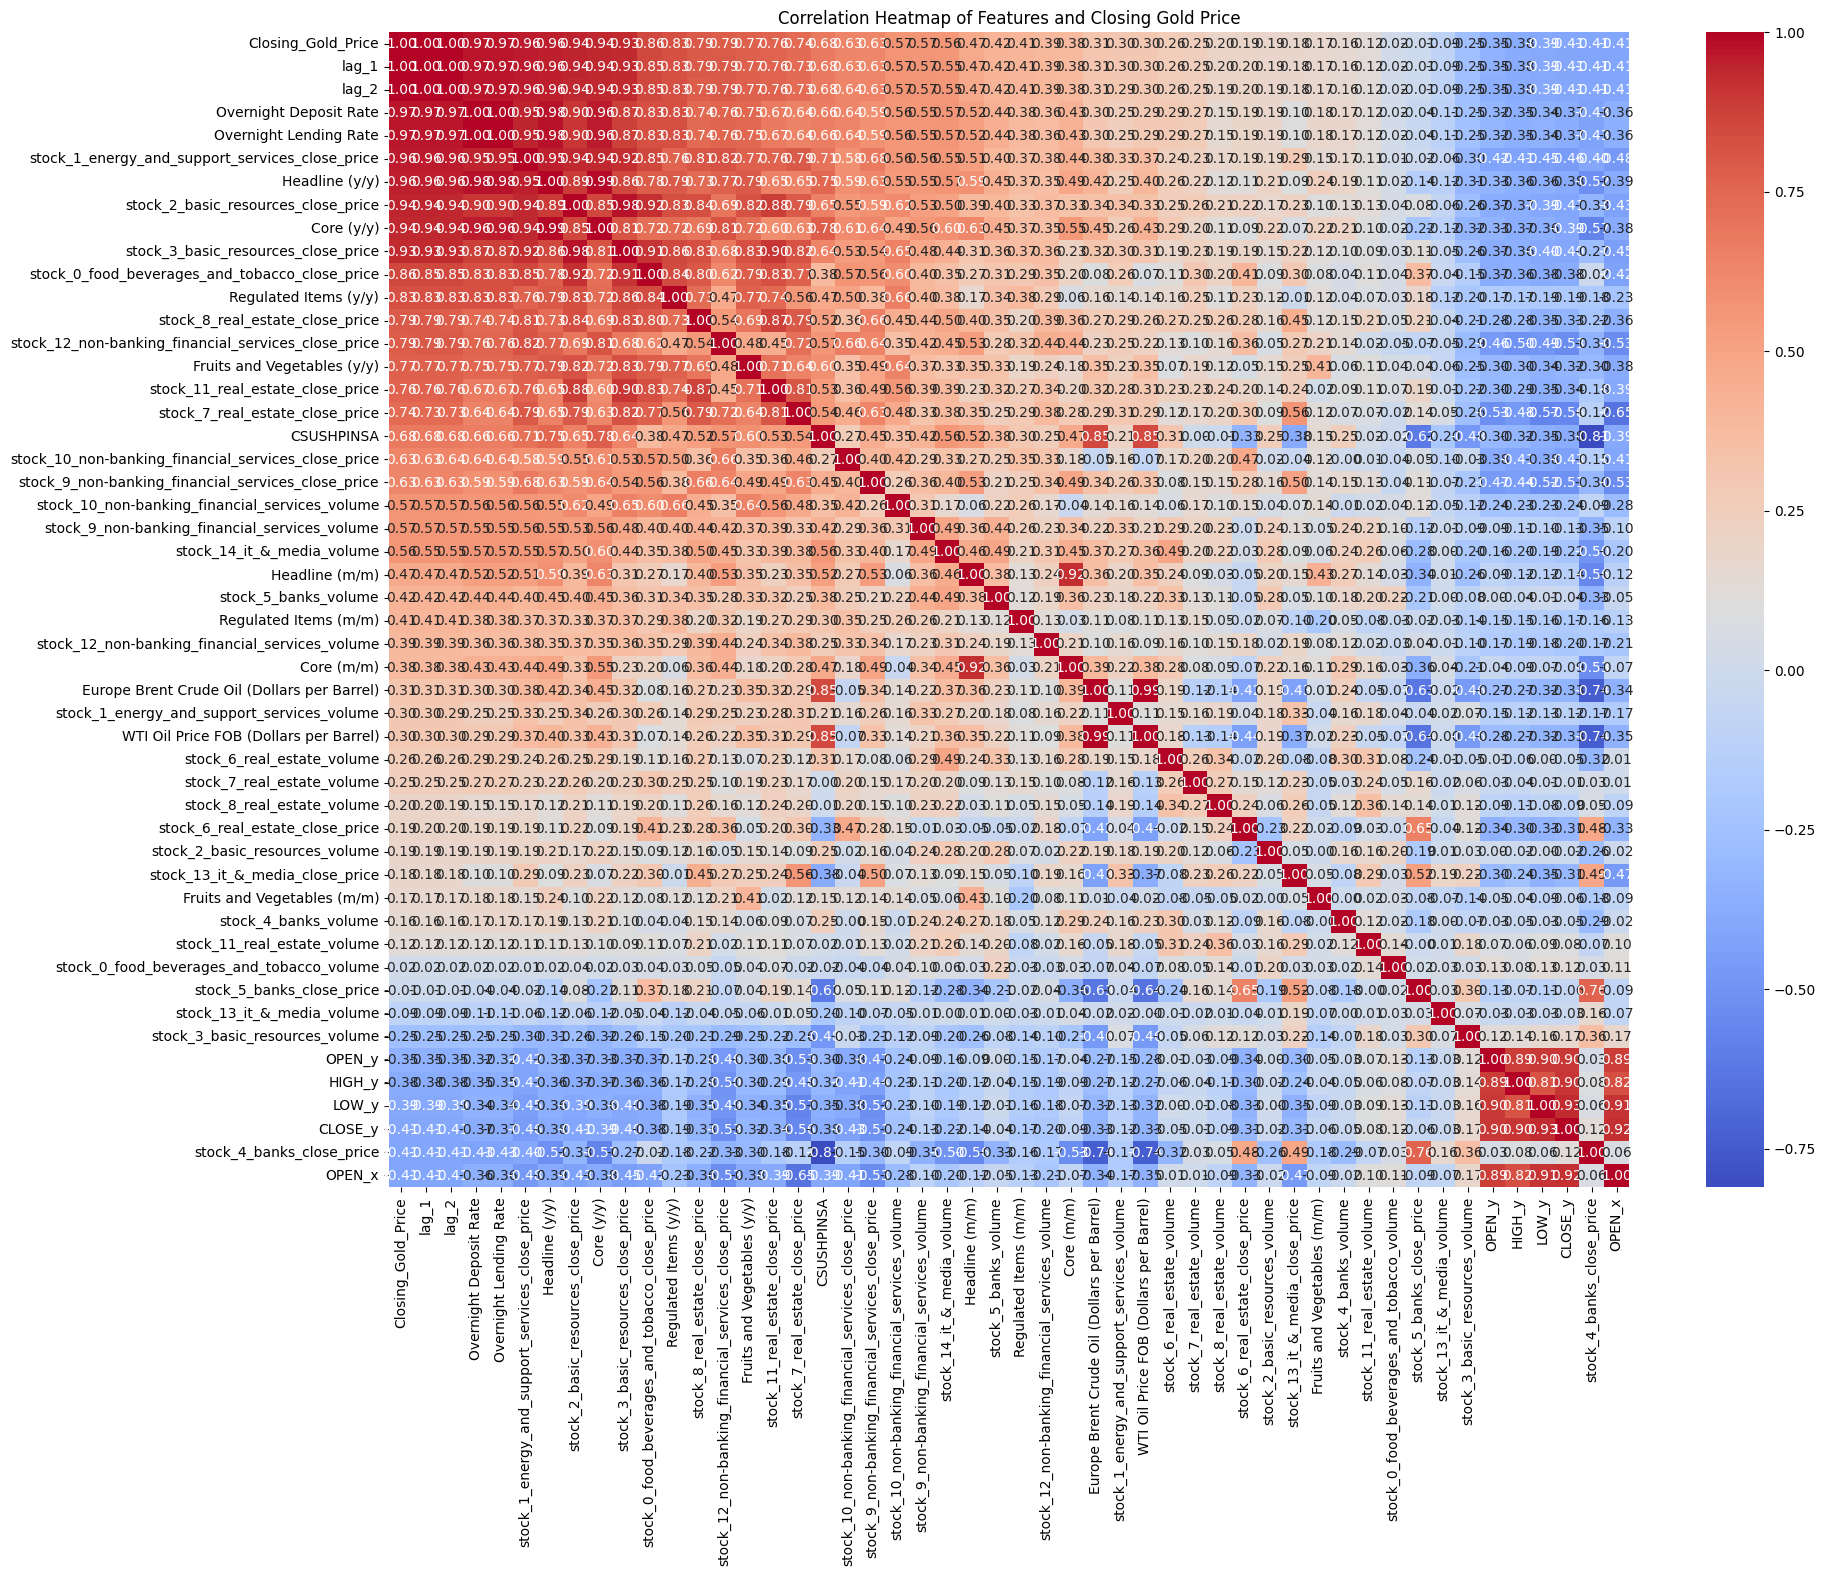

In [31]:
import seaborn as sns

# Assuming `df` is the dataset with your features and gold prices
df = merged.copy()  # Make a copy to work with

# drop non_numeric columns
df = df.select_dtypes(include=['int64', 'float64'])
# Step 2: Correlation Heatmap
plt.figure(figsize=(20,15))
correlation_matrix = df.corr()
top_feat = correlation_matrix.nlargest(50,'Closing_Gold_Price').index
# Visualizing the correlation matrix
sns.heatmap(correlation_matrix.loc[top_feat,top_feat], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features and Closing Gold Price')
plt.show()

1458 1458


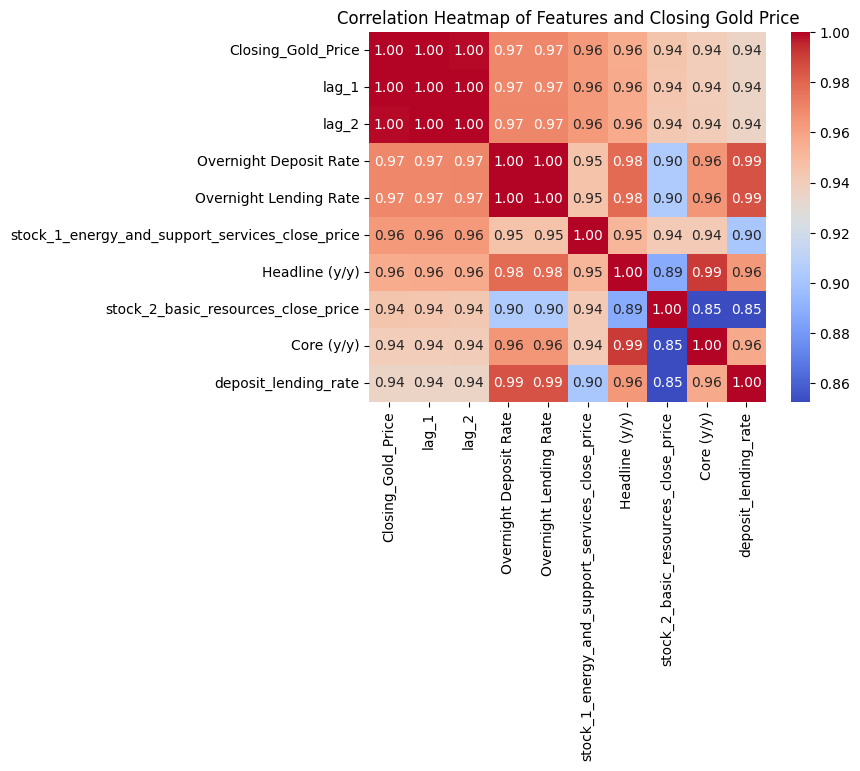

In [27]:
dff = merged.copy()
# print(dff)
print(len(dff.loc[:,'Overnight Deposit Rate']), len(dff.loc[:,'Overnight Lending Rate']))
dff['deposit_lending_rate'] = dff.loc[:,'Overnight Deposit Rate'] / dff.loc[:,'Overnight Lending Rate']
dff = dff.select_dtypes(include=['int64', 'float64'])

# correlation_matrix
u = dff.corr()
top_feat = u.nlargest(10,'Closing_Gold_Price').index

sns.heatmap(u.loc[top_feat,top_feat], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features and Closing Gold Price')
plt.show()

In [29]:
inflation_mom

,Date,Headline (m/m),Core (m/m),Regulated Items (m/m),Fruits and Vegetables (m/m)
0,2020-01-01,0.666,0.693,0.17,2.497
1,2020-01-02,0.666,0.693,0.17,2.497
2,2020-01-03,0.666,0.693,0.17,2.497
3,2020-01-04,0.666,0.693,0.17,2.497
4,2020-01-05,0.666,0.693,0.17,2.497
...,...,...,...,...,...
1455,2023-12-26,1.413,1.313,0.39,5.720
1456,2023-12-27,1.413,1.313,0.39,5.720
1457,2023-12-28,1.413,1.313,0.39,5.720
1458,2023-12-29,1.413,1.313,0.39,5.720


# Visualizing features with `Closing_Gold_prices`

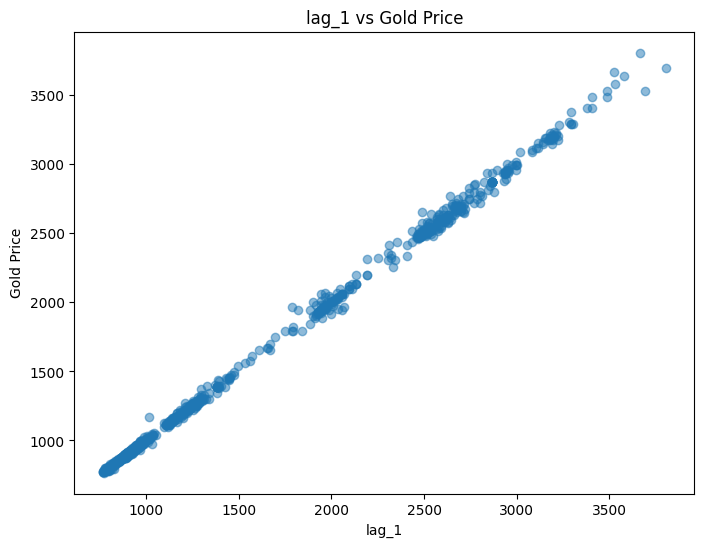

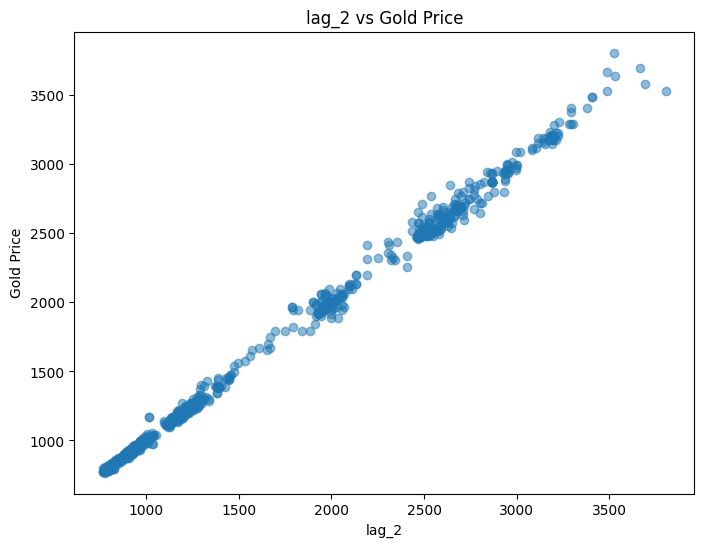

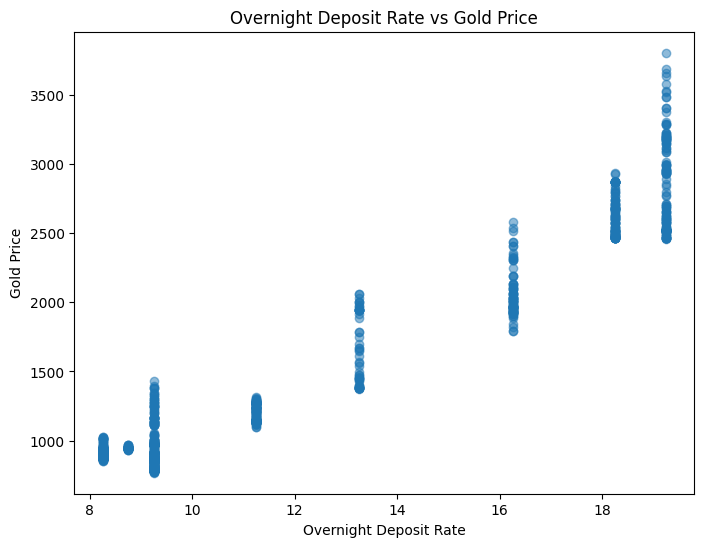

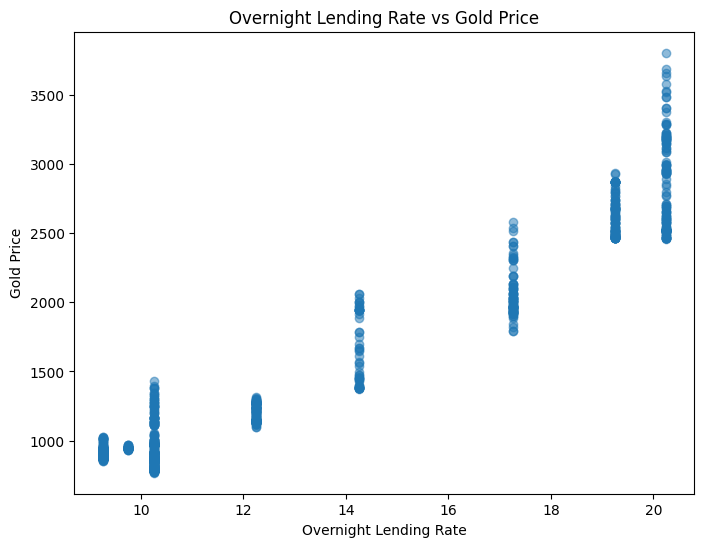

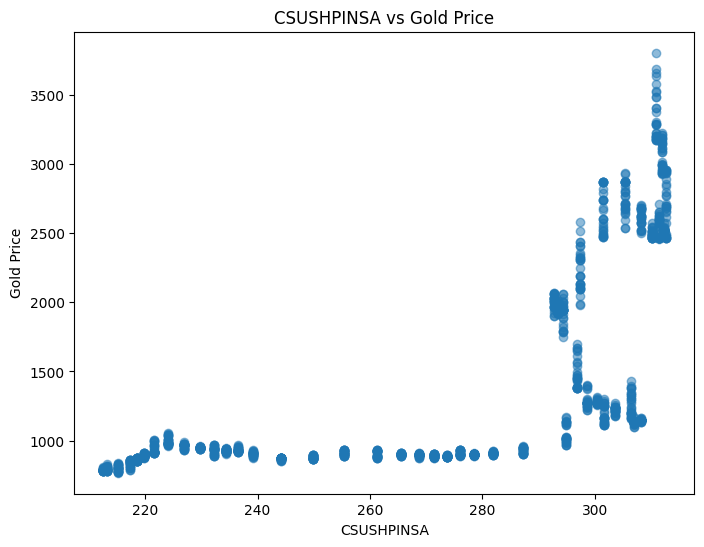

In [15]:
# Step 3: Visualizing individual feature relationships with gold price change
features = ['lag_1', 'lag_2', 'Overnight Deposit Rate', 'Overnight Lending Rate', 'CSUSHPINSA']  # Add more as needed

for feature in features:
    plt.figure(figsize=(8,6))
    plt.scatter(df[feature], df['Closing_Gold_Price'], alpha=0.5)
    plt.title(f'{feature} vs Gold Price')
    plt.xlabel(feature)
    plt.ylabel('Gold Price')
    plt.show()